# Physical Modelling of Mobile Robots

_**NOTE:** This notebook assumes, that you have already completed the *Code Debugging with LLMs Exercise*, where a simple kinematics-based mobile robot simulator has been implemented._

During the first two parts of the *Code Debugging with LLMs Exercise*, a simple 2D mobile robot simulator was implemented based on forward kinematics and transformations.

Kinematics focus on describing the motion of a mobile robot without considering the forces and torques that cause the motion. They provide a relationship between the robot's inputs, such as a command velocity, and its resulting position and orientation in space. Kinematic models are essential for planning and control, allowing the robot to compute trajectories and determine how it should move to reach a specific goal. However, kinematic models do not account for the robot's physical behavior, such as inertia and damping.

### Physical Behaviour

The goal of this exercise is to expand upon the kinematics-based simulator by incorporating a Turtlebot's physical model. Physical properties, such as mass and inertia, affect how quickly a mobile robot can respond to control inputs. Inertia, for example, causes the robot to resist changes in velocity, leading to delays and smoothing of acceleration and deceleration. Without accounting for these physical properties, the robot's behaviour will deviate from what the kinematic model predicts.

### Transfer Elements and Step Response

A transfer function is a mathematical representation that describes how an elements's output responds to its input. In the context of mobile robots, transfer elements can be used to model the dynamic behavior of the robot, capturing how the robot's physical properties affect its movement. Transfer elements alter an input signal (in our case robot velocity) based on the robot's approximated physical behaviour.

Transfer element behaviour can be visualised using a step response, which shows how a system in its idle state reacts to a sudden change in input. Usually, the applied input is a step at time 0 from 0 to 1 amplitude.
The next code cell visualises a typical signal inputted to a transfer element to measure a step response. It is calculated and visualised using the SciPy library [(documentation link)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.step.html).

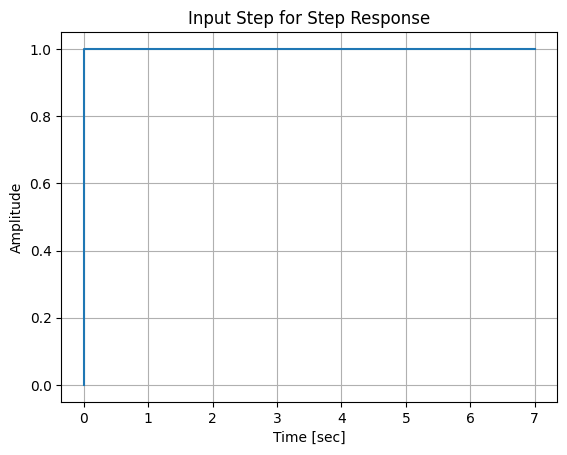

In [1]:
%matplotlib inline

from scipy import signal
import matplotlib.pyplot as plt

# Dummy system without amplification or phase shift
lti = signal.lti([1.], [1.])
t, y = signal.step(lti)

## Manually emphasise previous imput
t = [-0.00000000000001] + t.tolist()
y = [0.] + y.tolist()

# Plot the signal
plt.plot(t, y)
plt.xlabel('Time [sec]')
plt.ylabel('Amplitude')
plt.title('Input Step for Step Response')
plt.grid()

This course does not aim to provide a comprehensive overview over existing transfer elements. If the topic particularly interests you, please refer to chapter 2 in *Bishop, Richard C. Dorf Robert H. Modern control systems. 2011*. Instead, this exercise only introduces proportional second order (PT2) transfer elements. 

A PT2 transer element is user to model systems with both inertia and damping, which are typical in mobile robots. The PT2 block captures the second-order dynamics of the robot, representing how the robot's velocity (first order) and acceleration (second order) respond to control inputs. PT2 elements are defined using two values: a time constant $T$ and a damping factor $D$.

The next code cells visualise the PT2 step response with the same value for $T$ but three different values for $D$. The visualisations show that different values for the damping constant significantly affect the resulting curve's shape. Typically, the values of $T$ and $D$ are determined either through mathematical modelling or experiments.

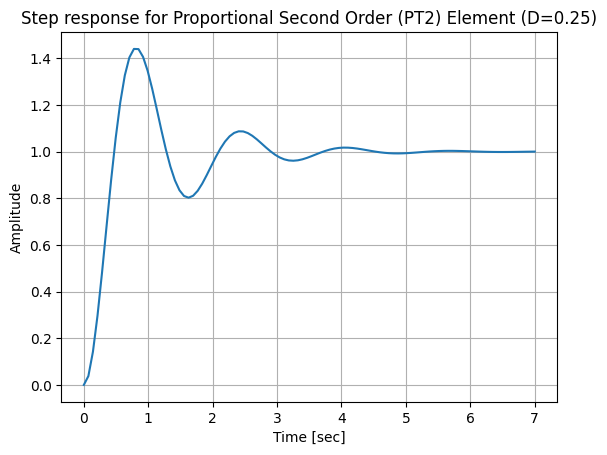

In [2]:
%matplotlib inline

from scipy import signal
import matplotlib.pyplot as plt

T=0.25
D=0.25

pt2 = signal.lti([1.], [T**2, 2*D*T, 1.])
t, y = signal.step(pt2)
plt.plot(t, y)

plt.xlabel('Time [sec]')
plt.ylabel('Amplitude')
plt.title('Step response for Proportional Second Order (PT2) Element (D={})'.format(D))
plt.grid()

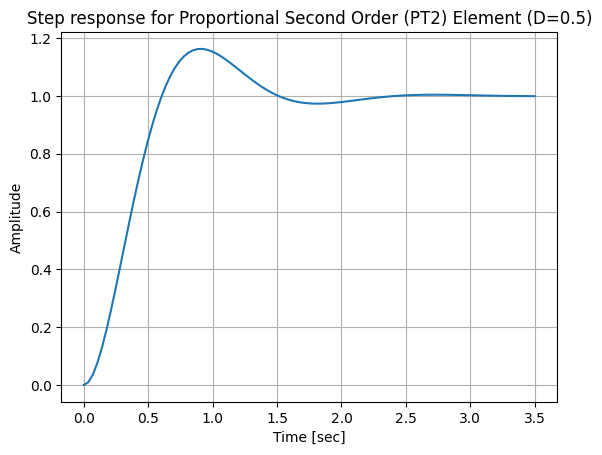

In [3]:
%matplotlib inline

from scipy import signal
import matplotlib.pyplot as plt

T=0.25
D=0.5

pt2 = signal.lti([1.], [T**2, 2*D*T, 1.])
t, y = signal.step(pt2)
plt.plot(t, y)

plt.xlabel('Time [sec]')
plt.ylabel('Amplitude')
plt.title('Step response for Proportional Second Order (PT2) Element (D={})'.format(D))
plt.grid()

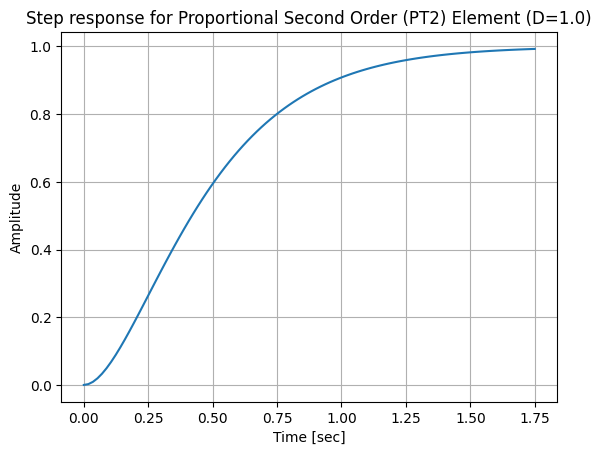

In [4]:
%matplotlib inline

from scipy import signal
import matplotlib.pyplot as plt

T=0.25
D=1.0

pt2 = signal.lti([1.], [T**2, 2*D*T, 1.])
t, y = signal.step(pt2)
plt.plot(t, y)

plt.xlabel('Time [sec]')
plt.ylabel('Amplitude')
plt.title('Step response for Proportional Second Order (PT2) Element (D={})'.format(D))
plt.grid()

### Turtlebot 3 Modelling

By sending command signals to a simulated Turtlebot 3 and localising the robot based on the laserscan, a rough system identification can be performed. When approximating the step response with a PT2 block, the resulting parameters are $T=0.12$ and $D=0.9$. Plotting the behaviour similarly to the earlier example results in the following code cell.

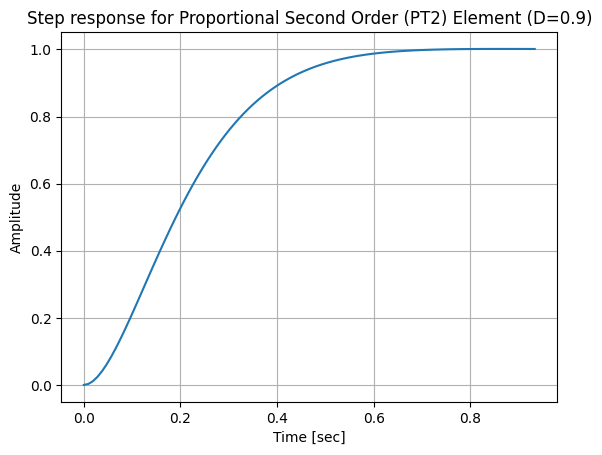

In [5]:
%matplotlib inline

from scipy import signal
import matplotlib.pyplot as plt

T=0.12
D=0.9

pt2 = signal.lti([1.], [T**2, 2*D*T, 1.])
t, y = signal.step(pt2)
plt.plot(t, y)

plt.xlabel('Time [sec]')
plt.ylabel('Amplitude')
plt.title('Step response for Proportional Second Order (PT2) Element (D={})'.format(D))
plt.grid()

### Time-Discrete Modelling

In previous visualisations, the transfer element was defined using the `lti` function from the `scipy.signal` module. `lti` stands for *linear time invariant* (i.e. one of the core properties of transfer blocks) and allows us to define a transfer element from the transfer function's nominator and denominator in the Laplace domain. While the resulting code is concise, we require `scipy.signal` to solve the reuslting time-continuous dynamic system based on a given input signal. Instead, this section presents a time-discrete approximation of a PT2 block in form of a difference equation.

A difference equation is an function that is dependent on its internal state as well as the previous sequence of input and output signals. This approximation of the transfer element is less computationally expensive, making it suitable for real-time processing applications. On the other hand,`scipy.signal` is geared towards offline analysis.

Since the derivation of the approximated transfer element is provided in full in the next code cell. If you are interested in the theory behind this approximation, refer to 13.4 in *Bishop, Richard C. Dorf Robert H. Modern control systems. 2011*. The following section uses the Tustin approximation obtained from the $z$ transform.

Since the transfer element has an internal state, it is implemented as a class. Upon instantiation, the transfer element is initialised in it's steady state and the parameters for $T$ and $D$ can be set. Furthermore, since the block acts as a time-discrete approximation, a sampling time $ts$ needs to be configured. The sampling time represents the taken time between controller updates. *(Hint: the difference to $dt$ the forward kinematics is that $ts$ needs to be constant for each update.)*

In [6]:
class PT2Block:
    """!@brief Discrete PT2 Block approximated using the Tustin approximation """
    def __init__(self, T=0, D=0, kp=1, ts=0, bufferLength=3) -> None:
        self.k1 = 0
        self.k2 = 0
        self.k3 = 0
        self.k4 = 0
        self.k5 = 0
        self.k6 = 0
        self.e = [0 for i in range(bufferLength)]
        self.y = [0 for i in range(bufferLength)]
        if ts != 0:  self.setConstants(T, D, kp, ts)
    #
    def setConstants(self, T, D, kp, ts):
        """ Updates controller constants """
        self.k1 = 4*T**2 + 4*D*T*ts + ts**2
        self.k2 = 2*ts**2 - 8*T**2
        self.k3 = 4*T**2 - 4*D*T*ts + ts**2
        self.k4 = kp*ts**2
        self.k5 = 2*kp*ts**2
        self.k6 = kp*ts**2
    #
    def update(self, e):
        """
        Performs one discrete controller update 
        
        Receives: Input signal [float]
        Returns: Output signal [float]
        """        
        # Update buffered input and output signals
        self.e = [e]+self.e[:len(self.e)-1]
        self.y = [0]+self.y[:len(self.y)-1]
        # Shorten variable names for better readability
        e = self.e
        y = self.y
        # Calculate output signal and return output
        y[0] = ( e[0]*self.k4 + e[1]*self.k5 + e[2]*self.k6 - y[1]*self.k2 - y[2]*self.k3 )/self.k1
        return y[0]

`PT2Block`'s update function performs one time-discrete update on the block. It takes the current input signal $e$ as an input and outputs the resulting output signal $y$. Since transfer block output is dependent on an internal state, all entries that are part of the input signal must be input in the order they occured in.

Finally, with the achieved understanding of time discrete transfer elements, we can now plot the Turtlebot3's behaviour using our own transfer element implementation (same plot as the last example).

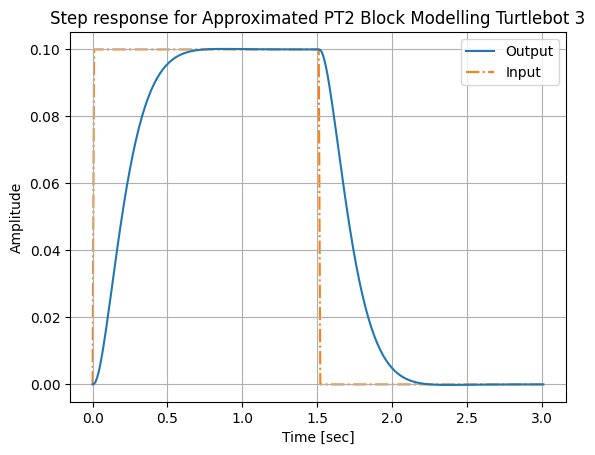

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt

## Set PT2 parameters to match Turtlebot3 behaviour
T=0.12
D=0.9

## Configure sampling time and shape of step
stepHeight = (0, 0.1) # Step from 0 to 0.1 amplitude
testTime = 3 # Forward simulation duration [sec]
ts = 1/100 # Sampling interval [sec]

## Create timestamps and 
samples = int(testTime*(1/ts)) + 2 # Number of discrete points in input signal
timeDiscrete = [ i*ts for i in range(samples) ] # 
inSignal = [stepHeight[0]] + [ stepHeight[1] for _ in range(int(samples/2)) ] + [ stepHeight[0] for _ in range(int(samples/2)-1) ]

## Instantiate PT2 block, set params and apply the block update for each data point in the input signal
PT2 = PT2Block(ts=ts, T=0.12, D=0.9)
PT2_output = [ PT2.update(s) for s in inSignal ]

## Plot input and output signals using matplotlib
plt.plot(timeDiscrete, PT2_output, label="Output", zorder=2)
plt.plot(timeDiscrete, inSignal, label="Input", zorder=1, linestyle="-.")

## Configure and show plot
plt.xlabel('Time [sec]')
plt.ylabel('Amplitude')
plt.title('Step response for Approximated PT2 Block Modelling Turtlebot 3')
plt.grid()
plt.legend()

### Physics-based Robot Simulation

Combine this implementation of a PT2 transfer element with the simulator achieved by completing the first two parts of the *Code Debugging with LLMs Exercise*. The PT2 behaviour must be applied to the mobile robot's linar velocity ($vt$) with the parameters $T$ and $D$ outlined before. Publish the resulting robot pose to ROS, similarly to exercise 2. After integrating the physical model into your simulator, you shoud see a change in behaviour compared to the previous exercise's simulator whenever the "robot" changes its speed.

_**Hint:** Keep $dt$ in the forward kinematics and $ts$ in the transfer element consistent and call the simulator update $\frac{1}{dt}=\frac{1}{ts}$ per second. This approach is required for the physical behaviour to occur in real-time._
